# $\color{red} {\text{Coordinate Descent}}$

> ## $\color{cyan}{\text{What is Coordinate Descent?}}$

>> **Coordinate descent** is an optimization algorithm that successively minimizes along coordinate directions to find the minimum of a function. At each iteration, the algorithm determines a coordinate or coordinate block via a coordinate selection rule, then exactly or inexactly minimizes over the corresponding coordinate hyperplane while fixing all other coordinates or coordinate blocks. A line search along the coordinate direction can be performed at the current iterate to determine the appropriate step size. Coordinate descent is applicable in both differentiable and derivative-free contexts.

> ## $\color{cyan}{\text{What types are done here?}}$

>> * random coordinate descent
>> * cyclic coordinate descent
>> * adaptive coordinate descent

In [17]:
#imports
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing
from scipy.optimize import fmin
from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp


In [18]:
def lf(wi, x, y, w,idx = 'N'):
  loss = 0
  if idx != 'N':
    w[idx] = wi
  for i in range(len(y)):
    if y[i] == 1:
      loss += np.log(1.0 + np.exp(-np.dot(w,x[i,:])))
    else:
      loss += np.log(1.0 + np.exp(np.dot(w,x[i,:])))
  return loss

In [19]:
# successfully replicated score function now with w as parameter
def test_score(x, y, w):
  pred_y = np.zeros(len(y))
  ll = 0
  err = 0
  for i in range(len(y)):
    one = 1.0/(1.0 + np.exp(-np.dot(w,x[i,:])))
    zero = 1.0 - one
    pred_y[i] = 1 if one > zero else 0
    if pred_y[i] != y[i]:
      err = err + 1
  return (1 - err/len(y))

In [20]:
# gradient function - V2
# will calculate gradient for all values at once
def gradient(x,y,w):
  # returns a (x.length,1) array of the P(y=1) for each x 
  pred = 1.0/(1.0 + np.exp(-np.dot(x,w)))
  pred = np.reshape(pred,(104,1))
  grad = np.dot(x.T,np.subtract(pred, y))
  return grad

In [21]:
# how to pick idx to minimize
def adaptive_idx(x,y,w):
  grad = gradient(x,y,w)
  max_i = np.argmax(abs(grad))
  return max_i

In [22]:
# minimize the loss function
# might redo so i have the learning rate
def update_wi(x, y, w, wi, index):
  updated_wi = fmin(lf,args=(x,y,w,index),x0 = wi, disp = False)
  return updated_wi

In [23]:
# data preprocessing
df = load_wine(as_frame = True)
# concatenating horizontally
data = pd.concat([df.data, df.target], axis = 1)
# slicing the data so only those of class 0 and 1 are included (shuffling included)
data = data.loc[data['target'] != 2].sample(frac = 1)
# get training and testing datasets
train, test = train_test_split(data,test_size = 0.2)
train_x = np.split(train,[13,14],axis = 1)[0].to_numpy()
train_y = np.split(train,[13,14],axis = 1)[1].to_numpy()
test_x = np.split(test,[13,14],axis = 1)[0].to_numpy()
test_y = np.split(test,[13,14],axis = 1)[1].to_numpy()

In [24]:
# baseline logistic regression - test
from sklearn.linear_model import LogisticRegression
#need to have penalty or else will overfit
lr = LogisticRegression(solver='lbfgs',max_iter=1000000,C=100000)
lr.fit(train_x, np.ravel(train_y))
score_star = lr.score(test_x,np.ravel(test_y))
print(score_star)
lr_pred_prob_test = lr.predict_proba(test_x)
lr_pred_prob_train = lr.predict_proba(train_x)
w_star = lr.coef_
b_star = lr.intercept_
# combine the w* and b* to get w'*
w_p_star = np.append(b_star, w_star)
print(w_p_star)
# calculate the final loss (log_loss function + maybe self-implemented function)
lr_loss_test = log_loss(np.ravel(test_y), lr_pred_prob_test, normalize=False)
lr_loss_train = log_loss(np.ravel(train_y), lr_pred_prob_train, normalize=False)
print(lr.n_iter_)
print(lr_loss_test)
print(lr_loss_train)

0.8846153846153846
[  9.87809124  12.21110578  -9.84584222 -28.45705992   6.15437298
  -0.52289785  10.39894976 -14.10947073  -4.28234518  13.1925701
  -4.21263603   0.61285854  -8.401319    -0.15129018]
[530]
38.312381214444535
0.00237948222261032


In [25]:
# add intercept column
train_int = np.ones((len(train_x),1))
test_int = np.ones((len(test_x),1))
train_x_b = np.hstack((train_int,train_x))
test_x_b = np.hstack((test_int,test_x))

In [26]:
# normalize the data
train_x_norm = preprocessing.normalize(train_x_b, norm = 'l2')
test_x_norm = preprocessing.normalize(test_x_b, norm = 'l2')

In [27]:
#random coordinate descent
rcd_loss = []
w_rcd = np.random.rand(14)
rcd_ct = 0
cur_rcd_loss = 10000
max_iter = 10000
while cur_rcd_loss > 1 and rcd_ct < max_iter:
   idx = randint(0,13)
   updated_wi = update_wi(train_x_norm,train_y,w_rcd,w_rcd[idx],idx)[0]
   w_rcd[idx] = updated_wi
   cur_rcd_loss = lf(1,train_x_norm,train_y,w_rcd)
   rcd_loss.append(cur_rcd_loss)
   print(cur_rcd_loss)
   rcd_ct += 1

/var/folders/wz/vhzwv2fs6vqg6zknn8vqfsk80000gn/T/ipykernel_96568/2385329997.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w[idx] = wi


79.43277837933422
78.73228376872866
78.12975068641158
67.77264168703493
64.56010882028059
63.4247274510269
62.292613225052754
62.1708732212617
62.05435206164916
61.073868823898394
60.600829501350525
60.585327441047006
59.97685719845763
59.33673610534105
59.19684883568043
59.12932837573651
59.06395438207114
58.97720743148877
58.54760652013806
58.14351866707462
58.13729792843038
57.98332030276141
57.199643468194886
56.938437532729544
56.93526956468535
56.93526956468535
56.92492698052024
56.92492698052024
56.62314803758442
56.4716629007698
54.67179237614081
52.54587384777274
52.183638810130844
52.183638810130844
52.161126737427296
52.089505314282306
52.027602160974254
51.69325892786347
49.4175743608642
48.80220849931612
48.80205562325579
48.80179339186786
48.78502805800722
48.77272366575653
48.769783944814726
48.760951426242606
48.76057912853079
48.68460435150256
48.68460435150256
48.59514196608998
48.59462869718593
48.44498746813755
48.33144539617439
48.212805453116864
48.12764516033435


In [28]:
print(test_score(test_x_b,test_y,w_rcd))
print(lf(1,test_x_norm,test_y,w_rcd))
print(w_rcd)
print(rcd_ct)

0.9615384615384616
1.753461271375936
[15932.10052164   211.08362894 -1468.39736963 -3892.96202386
   692.1924579    -25.20373324   983.37935718 -1380.97601682
 -3726.38977755  1408.36649738  -704.19779399  3576.66904439
 -1436.22752197   -18.40270586]
4994


/var/folders/wz/vhzwv2fs6vqg6zknn8vqfsk80000gn/T/ipykernel_96568/2553383530.py:7: RuntimeWarning: overflow encountered in exp
  one = 1.0/(1.0 + np.exp(-np.dot(w,x[i,:])))


In [29]:
#cyclic coordinate descent
ccd_loss = []
w_ccd = np.random.rand(14)
ccd_ct = 0
cur_ccd_loss = 10000
idx = 0
max_iter = 10000
cur_iter = 0
while cur_ccd_loss > 1 and ccd_ct < max_iter:
   idx = idx + 1 if idx + 1 < 14 else 0
   updated_wi = update_wi(train_x_norm,train_y,w_ccd,w_ccd[idx],idx)[0]
   w_ccd[idx] = updated_wi
   cur_ccd_loss = lf(1,train_x_norm,train_y,w_ccd)
   ccd_loss.append(cur_ccd_loss)
   print(cur_ccd_loss)
   ccd_ct += 1

70.54498446407901
70.51393697548549
70.50321923253632
69.97236665592483
69.15626199664939
69.12098830462013


/var/folders/wz/vhzwv2fs6vqg6zknn8vqfsk80000gn/T/ipykernel_96568/2385329997.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w[idx] = wi


68.99233121451353
67.13419147778382
66.6023443042191
65.06751626824308
62.98124357455301
62.90469554924433
58.79818273911375
54.37332168990503
54.293884699883236
54.27861914960536
54.27249343406747
53.85621635761174
53.29267144378688
53.27809431337221
53.195493553202994
52.27982289958697
52.12063604592408
51.06260834292727
49.839557801957234
49.79967971645516
47.07582767438146
44.06759103352294
44.00299681590281
43.99795731863211
43.99570207490942
43.6549534184401
43.25622100530315
43.249258955247726
43.19266699599864
42.73865106872626
42.71056937527905
41.93507004479063
41.16945617841119
41.1462073313613
39.2377125266763
37.081455430516286
37.02685663096955
37.026356792993646
37.026074885516934
36.739190229192246
36.45239928506144
36.44838060229369
36.40721068067115
36.183841190262015
36.1837943268704
35.588894481185456
35.08151679910019
35.06612083294059
33.67673337613956
32.07182046752761
32.024542518732346
32.024136319261345
32.024023972802325
31.777248524190522
31.567711840617786


In [30]:
print(test_score(test_x_b,test_y,w_ccd))
print(lf(1,test_x_norm,test_y,w_ccd))
print(w_ccd)
print(ccd_ct)

0.9230769230769231
3.020297627199361
[ 2.05213987e+04 -6.23671165e+02 -1.24033290e+03 -2.24363275e+03
  7.15284588e+02 -5.59272944e+01  8.98087149e+02 -2.04082578e+03
 -4.51919330e+03  1.52433733e+03 -1.77293487e+02  4.60489730e+03
 -1.29033452e+03 -1.52263242e+01]
2632


/var/folders/wz/vhzwv2fs6vqg6zknn8vqfsk80000gn/T/ipykernel_96568/2553383530.py:7: RuntimeWarning: overflow encountered in exp
  one = 1.0/(1.0 + np.exp(-np.dot(w,x[i,:])))


In [31]:
#adaptive coordinate descent
acd_loss = []
acd_dict = {}
w_acd = np.random.rand(14)
cur_acd_loss = 10000
acd_ct = 0
max_iter = 10000
while cur_acd_loss > 1 and acd_ct < max_iter:
  idx = adaptive_idx(train_x_norm,train_y,w_acd)
  if (idx in acd_dict):
    acd_dict[idx] += 1
  else:
    acd_dict[idx] = 1
  updated_wi = update_wi(train_x_norm, train_y,w_acd,w_acd[idx],idx)[0]
  w_acd[idx] = updated_wi
  cur_acd_loss = lf(1,train_x_norm,train_y,w_acd)
  acd_loss.append(cur_acd_loss)
  print(cur_acd_loss)
  acd_ct += 1

70.16346210700995
66.09779233396424
62.41815648313364
59.35393516428541
56.55349750238052
54.189406625029996
52.015930011858416
50.15721303625269
48.44122242822764
46.95580826814721
45.580656841665245
44.37727431851643
43.26082790159034
42.27455446791736
41.35772833778787
40.540770057621735
39.78023123872223
39.09772303203373
38.461132361364385
37.88634109397509
37.34927971990885
36.86139151842594


/var/folders/wz/vhzwv2fs6vqg6zknn8vqfsk80000gn/T/ipykernel_96568/2385329997.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w[idx] = wi


36.40514063165307
35.9886877724655
35.598601604307866
35.24104233963289
34.90560706026532
34.59696281856878
34.30704955991183
34.03927406210614
33.78755181775187
33.5543433727594
33.334841765511186
33.13090367974182
32.93875302065442
32.759849137534836
32.5910506957923
32.43346924498655
32.28469746704286
32.14560838278024
32.01410454117497
31.890825725581525
31.774264355790994
31.66480175629821
31.56122386955144
31.463890973624917
31.37162739845142
31.284755073165755
31.20239831691461
31.124742385081955
31.051077974242876
30.98152125059903
30.915507759079738
30.853141560262387
30.79387525569902
30.73782028819066
30.68452912905141
30.63409653720852
30.586106375529997
30.540634024990624
30.497354101357182
29.38389145970951
28.36497215584711
27.46152620759944
26.630088890098065
25.886001839894234
25.19798258346159
24.577899952539724
24.00183462012276
23.47940109560912
22.992263635599056
22.548493112223213
22.132997859904304
21.75276984713711
21.39574929531312
21.067880147025583
20.7590833

In [32]:
print(test_score(test_x_b,test_y,w_acd))
print(lf(1,test_x_norm,test_y,w_acd))
print(w_acd)
print(acd_ct)
print(acd_dict)

0.8846153846153846
5.448842376696856
[ 9.28685729e-01  1.31827194e+03 -1.80792240e+03 -3.62055222e+03
  8.56824553e+02 -2.32270331e+01  6.58581506e-01 -9.28848773e+02
  8.57210195e-01  1.59315087e+02 -3.46959584e+02  5.34594526e-01
 -4.74478570e+01 -1.98786702e+01]
10000
{13: 5000, 5: 2491, 4: 1069, 2: 41, 10: 23, 7: 26, 1: 1199, 3: 142, 9: 5, 12: 4}


/var/folders/wz/vhzwv2fs6vqg6zknn8vqfsk80000gn/T/ipykernel_96568/2553383530.py:7: RuntimeWarning: overflow encountered in exp
  one = 1.0/(1.0 + np.exp(-np.dot(w,x[i,:])))


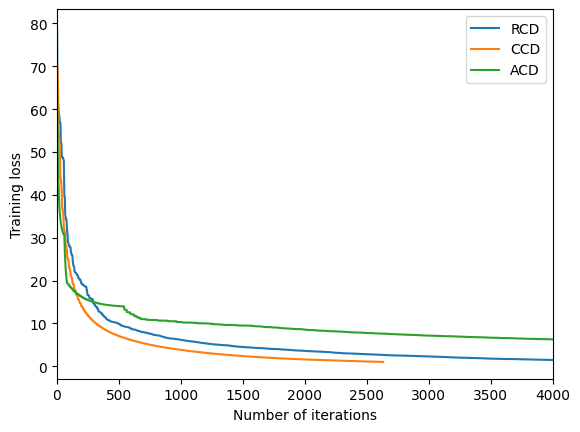

In [33]:
#create graph of each side by side
pp.xlabel('Number of iterations')
pp.ylabel('Training loss')
pp.xlim([0, 4000])
pp.plot(rcd_loss)
pp.plot(ccd_loss)
pp.plot(acd_loss)
pp.legend(['RCD','CCD','ACD'])
pp.show()